# This notebook loads trajectories of an absorptive bistability and applies diffusion maps to learn about the manifold the trajectory spans.

In [2]:
Regime = "absorptive_bistable" ## used to load appropraite file

#  loading trajectory and using manifold my diffusion map script.

In [3]:
## load trajectory data from file
import pickle

## diffusion maps
from diffusion_maps import run_diffusion_map

## numerical
import numpy as np

## plotting libraries
import matplotlib.pyplot as plt
# %matplotlib inline
from mpl_toolkits.mplot3d import axes3d
import matplotlib.cm as cm


## plotly graphs
import plotly.plotly as py
import plotly.graph_objs as go

import random

import collections

In [4]:
## Style for plots

plt.style.use("ggplot")

## Functions for Plotting

In [5]:
def show_colorbar(x_index, name):
    ## show color scheme
    # http://matplotlib.org/examples/color/colormaps_reference.html

    gradient = np.linspace(0, 1, x_index)
    gradient = np.vstack((gradient, gradient))

    fig, axes = plt.subplots(figsize=(24,2))
    axes.set_title( ' colormaps', fontsize=14)
    axes.imshow(gradient, aspect='auto', cmap=plt.get_cmap(name))

    plt.axis("off")
    plt.show()

In [6]:
def colored_3d_plot(data,elev=45, azim=45):
    ## Figure 
    fig = plt.figure(figsize=(24,20))
    ax = fig.add_subplot(111, projection='3d')
    to_plot_=[[x[i] for x in data] for i in xrange(0,3)]

    x_index = len(np.asarray(to_plot_).T)/params['Ntraj']

    color_list = np.concatenate([np.linspace(0, 1, x_index)] * params['Ntraj'])
    colors = cm.jet(color_list)
    ax.scatter(*to_plot_,c=colors)
    ax.view_init(elev=elev, azim=azim)
    show_colorbar(x_index,'jet')

In [7]:
def plot_by_operator(data,traj1,elev=90,azim=45,dist = None,operator = "",filename = None):
    if isinstance(operator,collections.Iterable):
        num_expects = operator
    else:
        raise ValueError("operator type not implemented")
       
    ## sort data by expected photon number
    num_expects_indices = [(i,n) for i,n in enumerate(num_expects)]
    sorted_num_expects = sorted(num_expects_indices, key = lambda z: z[1])
    data_by_num = [data[i[0]] for i in sorted_num_expects]

    ## Figure 
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111, projection='3d')
    to_plot_=[[x[i] for x in data_by_num] for i in xrange(0,3)]

    x_index = len(np.asarray(to_plot_).T)
    color_list = np.concatenate([np.linspace(0, 1, x_index)] )
    colors = cm.jet(color_list)
    ax.scatter(*np.asarray(to_plot_),c=colors)
    ax.view_init(elev=elev, azim=azim)
    if not dist is None:
        ax.dist = dist 
    if not filename is None:
        fig.savefig(filename,bbox_inches='tight')

    ## color bar    
#     show_colorbar(x_index,'jet')

In [8]:
## Usage:
# fig = make_plotly_3d_scatterplot(data,traj1,operator = traj_expects1[5])
# py.iplot(fig, filename='3d-scatter-colorscale')

def make_plotly_3d_scatterplot(data,traj1,operator = ""):
    if isinstance(operator,collections.Iterable):
        num_expects = operator
    else:
         raise ValueError("operator type not implemented")

    x,y,z = np.asarray(data).T
    i = num_expects
    
    trace1 = go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='markers',
        marker=dict(
            size=4,
            color=i,                # set color to an array/list of desired values
            colorscale='Viridis',   # choose a colorscale
            opacity=0.8
        )
    )

    data_plotly = [trace1]
    layout = go.Layout(
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=0
        )
    )
    fig = go.Figure(data=data_plotly, layout=layout)
    return fig

# Diffusion maps

In [103]:
# ## using outputs from generate_diffussion_map_data()

# _, e_vecs = generate_diffussion_map_data(...)

def generate_diffussion_map_data(traj_data,
                                 traj_expects,
                                 diffusion_params = None,  ## some default parameters
                                 metric = None, ## None will default to "euclidean" metric
                                ):
    if metric is None:
        metric = "euclidean"
    if diffusion_params is None:
        diffusion_params = {
                    "gaussian_epsilon": 0.15,  ## width of Gaussian kernel.
                    "num_neighbors" : 100,  ## cutoff of number of neighbors, if using epsilon_cutoff
                    "alpha": 1.,  ## coefficient to use for diffusion maps. See the wikipedia article.
                    "eigen_dims" : 4, ## number of lower dimensions to consider, i.e. number of eigenvectors to find.
                   }

    traj1 = traj_data
    traj_expects1 = traj_expects

    diffusion_params["data_size"] = len(traj1) ## total number of points

    ######

    assert len(traj1) == len(traj_expects1)
    print "Number of points: " + str(len(traj1))

    if metric == "euclidean":
        e_vals, e_vecs = run_diffusion_map(traj1.tolist(),
                                       diffusion_params,
                                       symmetric=True,
                                       neighbor_selection = "num_neighbors")
    elif metric == "FS_metric":
        e_vals, e_vecs = run_diffusion_map(traj1.tolist(),
                                           diffusion_params,
                                           symmetric=True,
                                           metric = "FS_metric",
                                           neighbor_selection = "num_neighbors")
    else:
        raise ValueError("Unknown metric")
    return e_vals, e_vecs,
        

# Loading from other pkl file...

In [10]:
## load trajectory data from file

pkl_file = open('../SDEs/trajectory_data/QSD_'+ Regime +'.pkl', 'rb')
pkl_dict = pickle.load(pkl_file)
pkl_file.close()

In [120]:
## pre-process expectation values

traj_expects = np.concatenate(pkl_dict['expects']).real

In [121]:
pkl_dict['expects'].shape

(10, 5000, 9)

In [122]:
traj_expects.shape

(50000, 9)

In [123]:
pkl_dict['psis'].shape

(10, 5000, 100)

In [12]:
Ntraj,duration,Nfock = pkl_dict['psis'].shape

In [13]:
##  Extract data into points of format (psi.real,psi.imag) from all trajectories.

traj_data = np.concatenate(
            [[ np.concatenate([f(pkl_dict['psis'][traj_num][time_num]) 
                for f in (lambda x: x.real, lambda x: x.imag) ]) 
                    for traj_num in range(Ntraj)]
                        for time_num in range(int(duration))])

In [88]:
traj_data.shape

(50000, 200)

In [14]:
print 'Total number of points: ' + str(len(traj_data))

Total number of points: 50000


In [15]:
###

# EXPERIMENTS BELOW

In [ ]:
###

# Experiment 1

Explore the parameters below

## Running Diffusion Map and Saving Result

In [111]:
# ## Lists over which to run the diffusion map algorithm

# points_per_sample = [1000,5000,10000]
# # points_per_sample = [500]  ## for testing purposes
# azim_range = range(0,360,360)
# epsilon_arr = np.linspace(0.05,0.5, 10)
# num_neighbors_range = [100]

# ## How much to down sample depends on the number of points we wish to use and the total trajectory length.
# total_len = len(traj_data)
# down_sample_arr = map(lambda points_to_use: int(total_len / points_to_use),points_per_sample)

In [112]:
# ## Running the algorithm for all parameters.

# def run_diffusion_maps_and_save_results():
#     # Generate experiment_dict_1. Takes a long time

#     experiment_dict_1 = {}

#     for down_sample in down_sample_arr:
#         for epsilon in epsilon_arr:
#             for num_neighbors in num_neighbors_range:
#                 for metric in (None,"FS_metric"):
#                     diffusion_params = {
#                                 "gaussian_epsilon": epsilon,  ## width of Gaussian kernel.
#                                 "num_neighbors" : num_neighbors,  ## cutoff of number of neighbors, if using epsilon_cutoff
#                                 "alpha": 1.,  ## coefficient to use for diffusion maps. See the wikipedia article.
#                                 "eigen_dims" : 6, ## number of lower dimensions to consider, i.e. number of eigenvectors to find.
#                                }
#                     experiment_dict_1[(down_sample,epsilon,num_neighbors,metric)] = generate_diffussion_map_data(
#                                                                             down_sample,diffusion_params,metric)

#     ## Save results from analysis

#     output = open( "./analysis_results_data/diffusion_map_absorptive_bistability_experiment1.pkl", 'wb')
#     pickle.dump(experiment_dict_1, output,protocol=0)
#     output.close()

In [126]:
### Run and save results  
### WARNING: THIS IS THE PART THAT TAKES A LONG TIME.

# run_diffusion_maps_and_save_results()

## load results from file

In [114]:
# pkl_file = open("./analysis_results_data/diffusion_map_absorptive_bistability_experiment1.pkl", 'rb')
# experiment_dict_1 = pickle.load(pkl_file)
# pkl_file.close()

## Plot results

In [115]:
# def plot_experiment_result(down_sample, epsilon, num_neighbors, metric, obs_num = 4,dist = 5.,filename=None):
#     ## load data from experiment_dict_1

#     down_sample,epsilon,num_neighbors,metric = down_sample, epsilon, num_neighbors, metric
#     _,e_vecs = experiment_dict_1[(down_sample,epsilon,num_neighbors,metric)]

#     ## Getting the right trajectory from data

#     traj1 = traj_data[0::down_sample]
#     traj_expects1 = traj_expects[:,::down_sample]

#     ## Plotting outputs

#     data = e_vecs.T[1:4].T
    
# #     for azim in azim_range:
# #         plot_by_operator(data,traj1,operator=traj_expects1[obs_num],azim=azim,filename)

#     plot_by_operator(data,traj1,operator=traj_expects1[obs_num],azim=0.,dist = dist,filename=filename)

In [105]:
## Euclidean 

# for epsilon_el in epsilon_arr:
#     filename = './Figures/euclidean_absorptive_bistable_' + '%.5f' % (epsilon_el) + ".pdf"
#     plot_experiment_result(down_sample_arr[0], epsilon_el,num_neighbors_range[-1],None,filename=filename)

In [157]:
# plot_experiment_result(down_sample_arr[1], epsilon_arr[0],num_neighbors_range[-1],"FS_metric",dist = 5.)

In [158]:
# for epsilon_el in epsilon_arr:
#     filename = './Figures/FS_metric_absorptive_bistable_' + '%.5f' % (epsilon_el) + ".pdf"
#     plot_experiment_result(down_sample_arr[-1], epsilon_el,num_neighbors_range[-1],"FS_metric",dist = 5.,filename=filename)

In [159]:
# for epsilon_el in epsilon_arr:
#     filename = './Figures/FS_metric_absorptive_bistable_Jz_' + '%.5f' % (epsilon_el) + ".pdf"
#     plot_experiment_result(down_sample_arr[-1], epsilon_el,num_neighbors_range[-1],"FS_metric",obs_num=2,filename=filename)

In [160]:
# for epsilon_el in epsilon_arr:
#     filename = './Figures/FS_metric_absorptive_bistable_Jm_' + '%.5f' % (epsilon_el) + ".pdf"
#     plot_experiment_result(down_sample_arr[-1], epsilon_el,num_neighbors_range[-1],"FS_metric",obs_num=1,filename=filename)

In [161]:
# for epsilon_el in epsilon_arr:
#     filename = './Figures/FS_metric_absorptive_bistable_aJp_' + '%.5f' % (epsilon_el) + ".pdf"
#     plot_experiment_result(down_sample_arr[-1], epsilon_el,num_neighbors_range[-1],"FS_metric",obs_num=5,filename=filename)

In [162]:
# for epsilon_el in epsilon_arr:
#     filename = './Figures/FS_metric_absorptive_bistable_a_' + '%.5f' % (epsilon_el) + ".pdf"
#     plot_experiment_result(down_sample_arr[-1], epsilon_el,num_neighbors_range[-1],"FS_metric",obs_num=0,filename=filename)

In [163]:
# for epsilon_el in epsilon_arr:
#     filename = './Figures/FS_metric_absorptive_bistable_aa_' + '%.5f' % (epsilon_el) + ".pdf"
#     plot_experiment_result(down_sample_arr[-1], epsilon_el,num_neighbors_range[-1],"FS_metric",obs_num=3,filename=filename)

# Experiment 2

Vary epsilon over a wider range than in experiment 1.

In [125]:
## sample 

sample_size = 5000

random_array = random.sample(range(Ntraj*duration),sample_size)
traj1 = np.asarray([traj_data[i] for i in random_array])
traj_expects1 = np.asarray([traj_expects[i] for i in random_array])

In [126]:
traj_data.shape

(50000, 200)

In [127]:
traj_expects.shape

(50000, 9)

In [138]:
def make_data_eps(epsilon = 0.5):

    num_neighbors = 300
    metric = "FS_metric"

    diffusion_params = {
            "gaussian_epsilon": epsilon,  ## width of Gaussian kernel.
            "num_neighbors" : num_neighbors,  ## cutoff of number of neighbors, if using epsilon_cutoff
            "alpha": 1.,  ## coefficient to use for diffusion maps. See the wikipedia article.
            "eigen_dims" : 6, ## number of lower dimensions to consider, i.e. number of eigenvectors to find.
           }
    _,e_vecs = generate_diffussion_map_data(traj1,traj_expects1,diffusion_params,metric)

    data = e_vecs.T[1:4].T
    
    return data

In [139]:
epsilon_list = [0.1,0.5,1.0]

In [140]:
data_dict = {}

In [141]:
for eps in epsilon_list:
    data_dict[eps] = make_data_eps(epsilon = eps)
    
data_dict['traj1'] = traj1
data_dict['operator_expects'] = traj_expects1

data_dict

Number of points: 5000
using num_neighbors  
Number of points: 5000
using num_neighbors  
Number of points: 5000
using num_neighbors  


{0.1: array([[ -1.22143163e-03,  -6.02832252e-02,   2.26661074e-03],
        [  3.95304917e-01,   4.97728043e-03,  -2.87589521e-02],
        [  3.95261781e-01,   4.42796404e-03,  -2.94545229e-02],
        ..., 
        [ -6.03560300e-05,  -6.02017697e-02,   4.56479803e-03],
        [ -3.22358716e-04,  -6.13371201e-02,   4.34280015e-03],
        [ -1.47177233e-03,  -6.10246697e-02,   2.76834319e-04]]),
 0.5: array([[-0.09300315, -0.01056883, -0.10550645],
        [-0.31258239,  0.15719926, -0.01788828],
        [-0.31226077,  0.17219523, -0.01242688],
        ..., 
        [-0.08779428, -0.08887179,  0.20536517],
        [-0.04171427,  0.0317335 , -0.37427449],
        [-0.07043993, -0.03541264, -0.2566284 ]]),
 1.0: array([[-0.18014491,  0.05137373,  0.03077561],
        [ 0.05317243,  0.02592178,  0.37810662],
        [ 0.08419614,  0.02762253,  0.249616  ],
        ..., 
        [ 0.02690339, -0.27050678, -0.03871039],
        [-0.09275881,  0.38550221,  0.16151079],
        [-0.0043

## Save Experiment 2

In [142]:
output = open( "./analysis_results_data/diffusion_map_absorptive_bistability_QSD_experiment2.pkl", 'wb')
pickle.dump(data_dict, output,protocol=0)
output.close()

## Load experiment 2

In [143]:
pkl_file = open( "./analysis_results_data/diffusion_map_absorptive_bistability_QSD_experiment2.pkl", 'rb')
data_dict = pickle.load(pkl_file)
pkl_file.close()

In [144]:
### View figures interactively

# %matplotlib auto
# plot_by_operator(data_dict[0.1],traj1,elev=-70,azim=50,dist = 10,operator = traj_expects1[1],filename = None)

In [145]:
%matplotlib inline

In [146]:
traj_expects1.T

array([[-4.73515489, -0.31348984, -4.35049794, ..., -0.25189967,
        -0.37552695, -0.34718121],
       [-0.44915705, -0.28464709, -0.06969244, ..., -0.28361099,
        -0.33865671, -0.2659497 ],
       [-0.05467158, -0.41001847, -0.458681  , ..., -0.39853365,
        -0.36760828, -0.42293814],
       ..., 
       [-0.44915705, -0.28464709, -0.06969244, ..., -0.28361099,
        -0.33865671, -0.2659497 ],
       [-0.44915705, -0.28464709, -0.06969244, ..., -0.28361099,
        -0.33865671, -0.2659497 ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

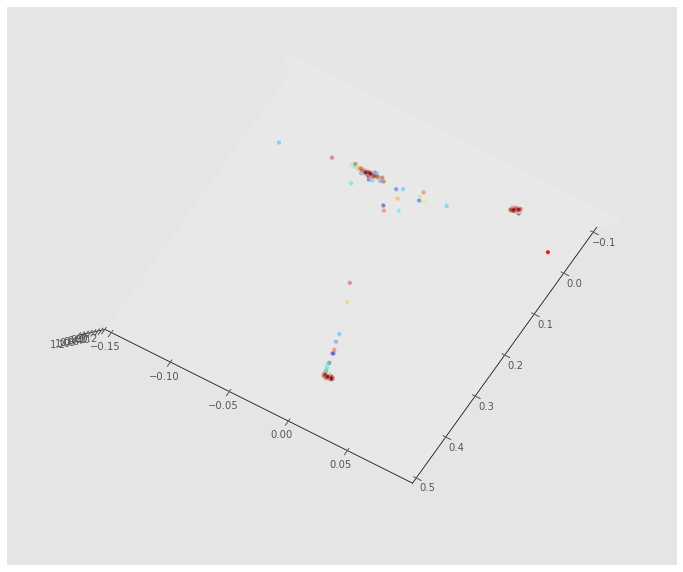

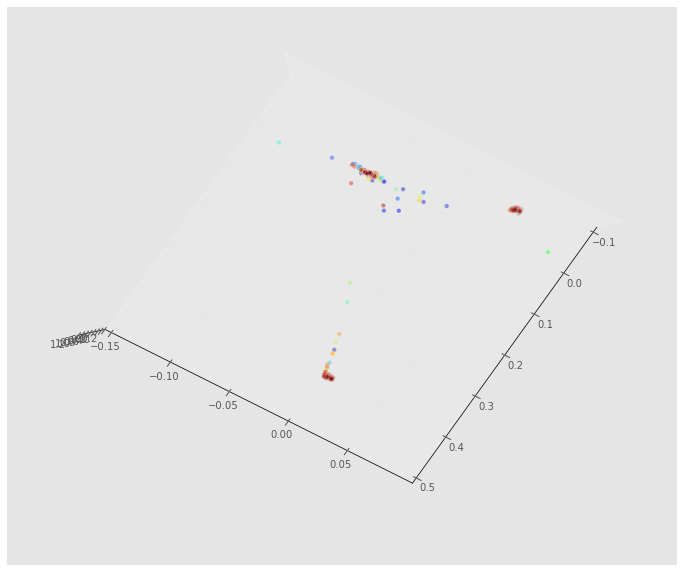

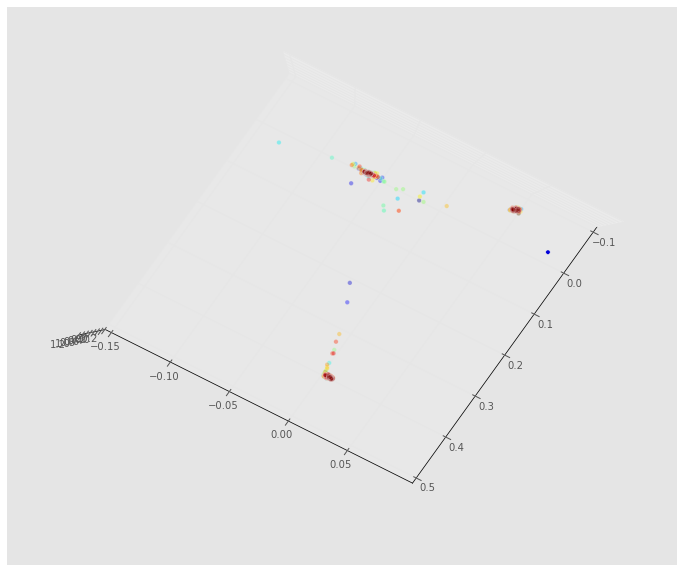

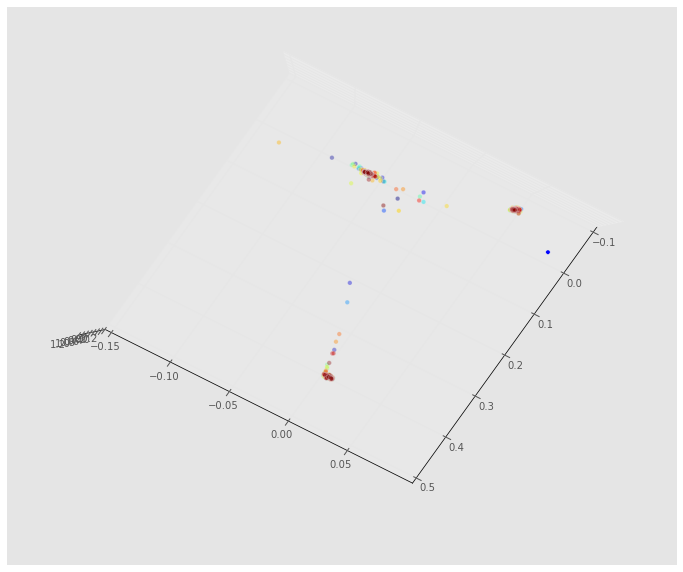

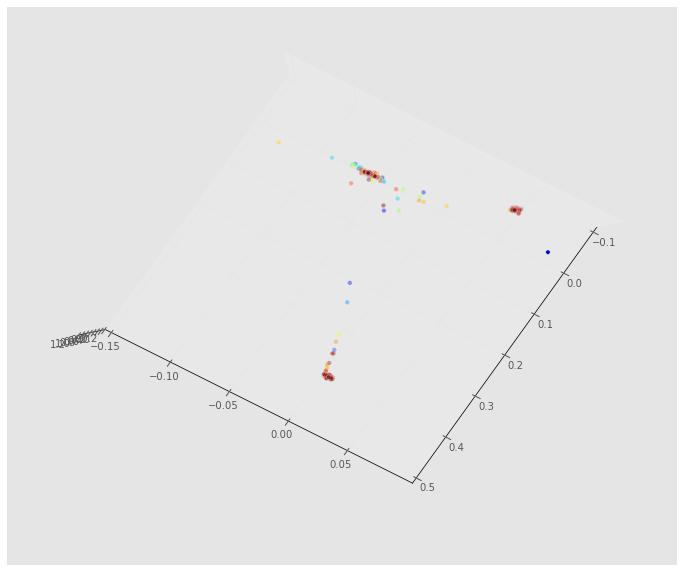

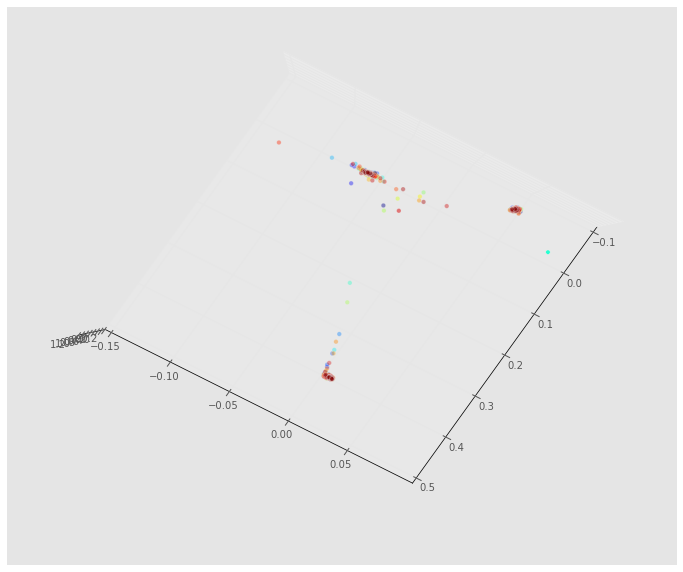

In [147]:
for obs in range(6):
    plot_by_operator(data_dict[0.1],traj1,elev=90,azim=30,dist = 10,operator = traj_expects1.T[obs],filename = "./Figures/FS_absorptive_bistability_QSD_eps0.1_obs"+str(obs)+".pdf")

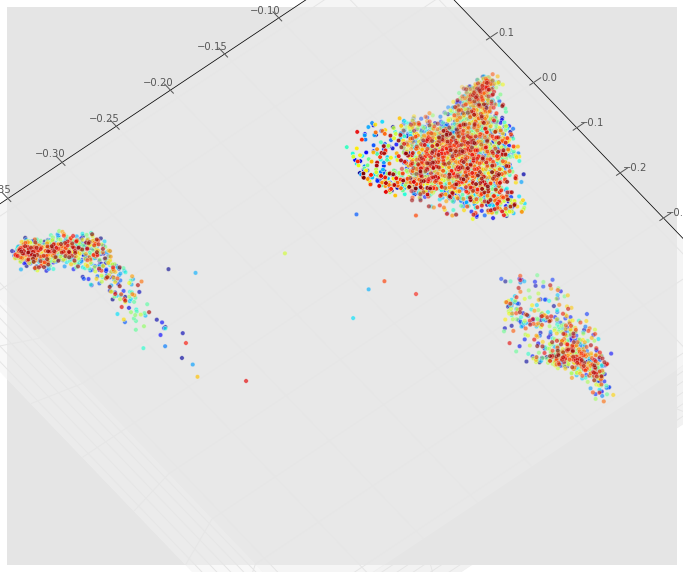

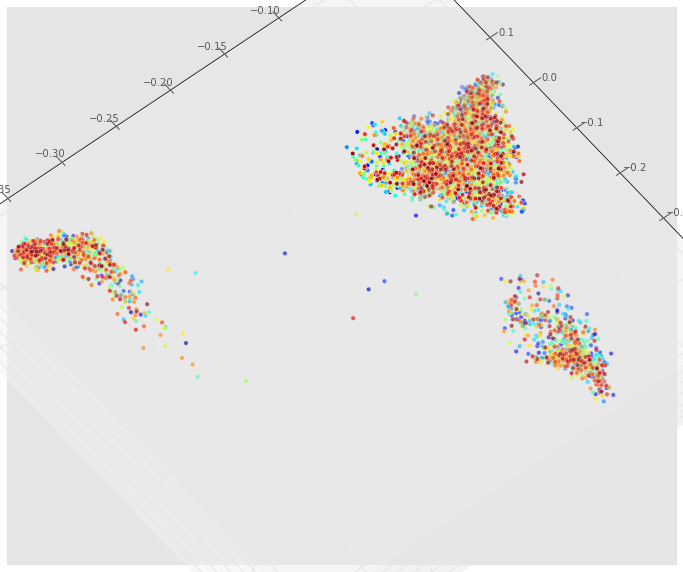

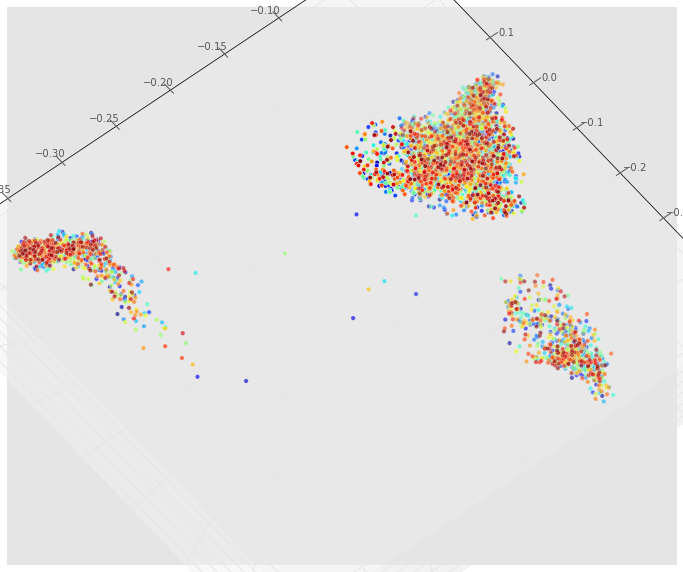

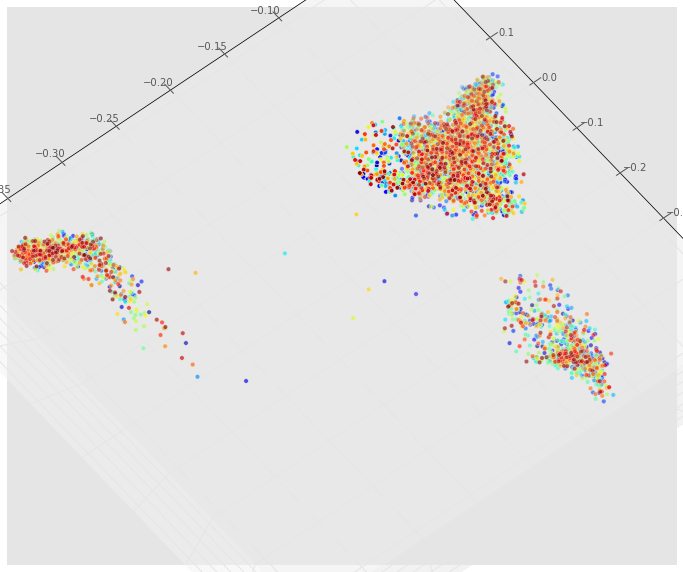

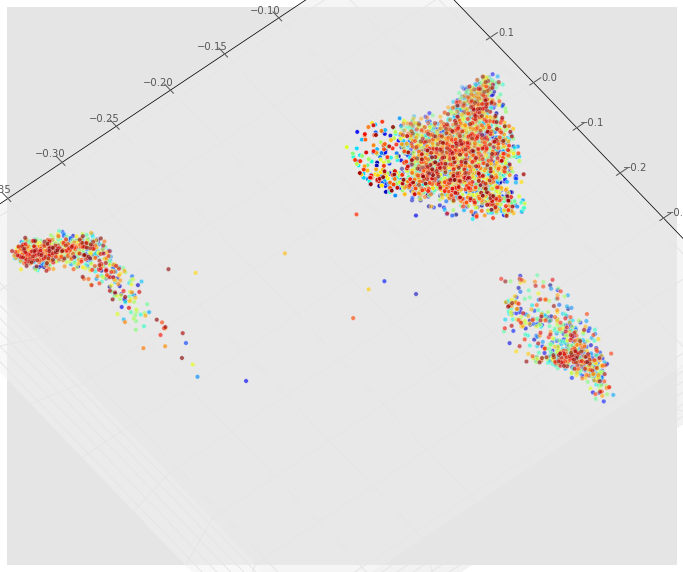

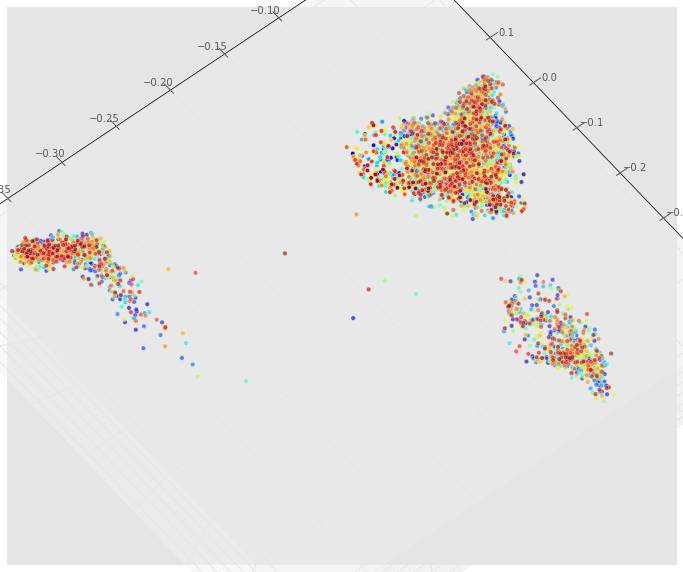

In [148]:
for obs in range(6):
    plot_by_operator(data_dict[0.5],traj1,elev=90,azim=230,dist = 6,operator = traj_expects1.T[obs],filename = "./Figures/FS_absorptive_bistability_QSD_eps0.5_obs"+str(obs)+".pdf")

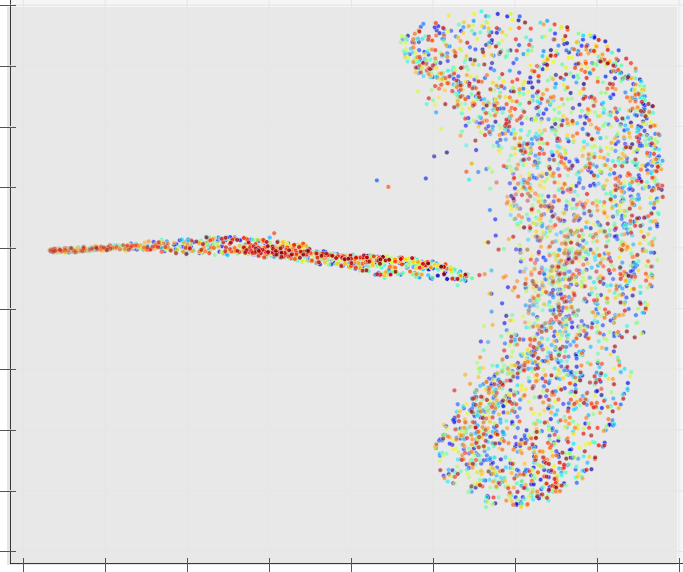

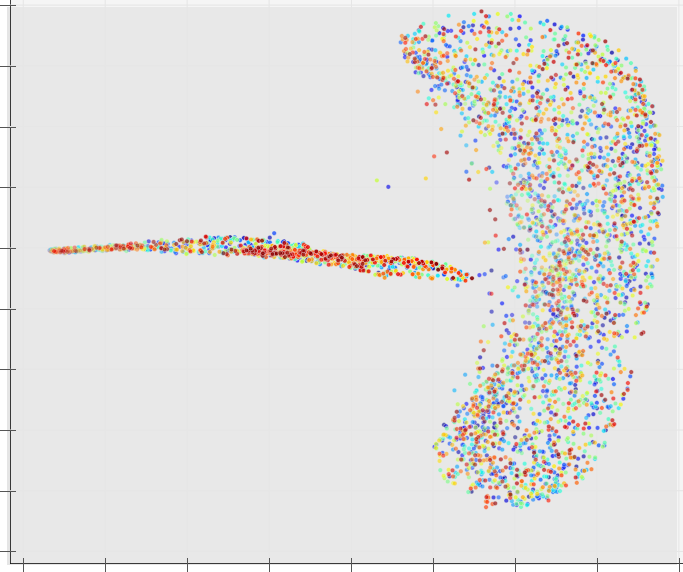

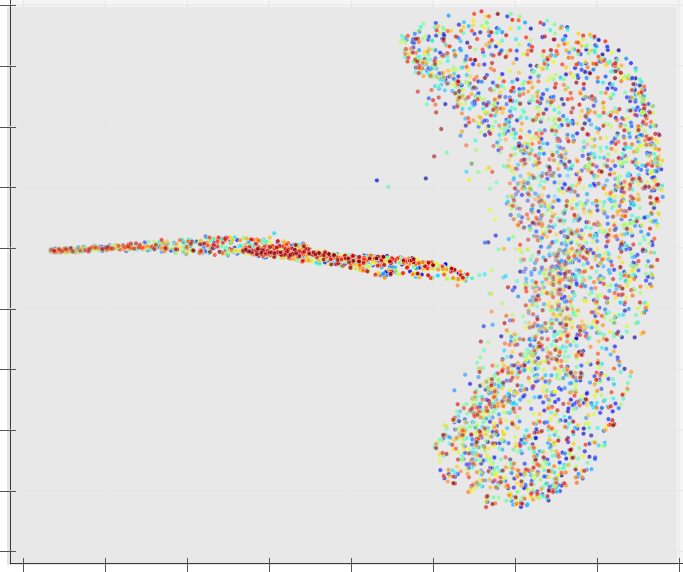

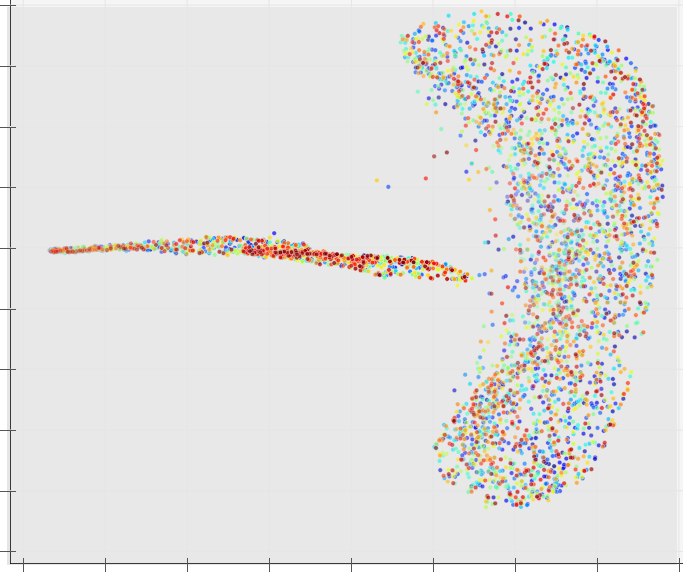

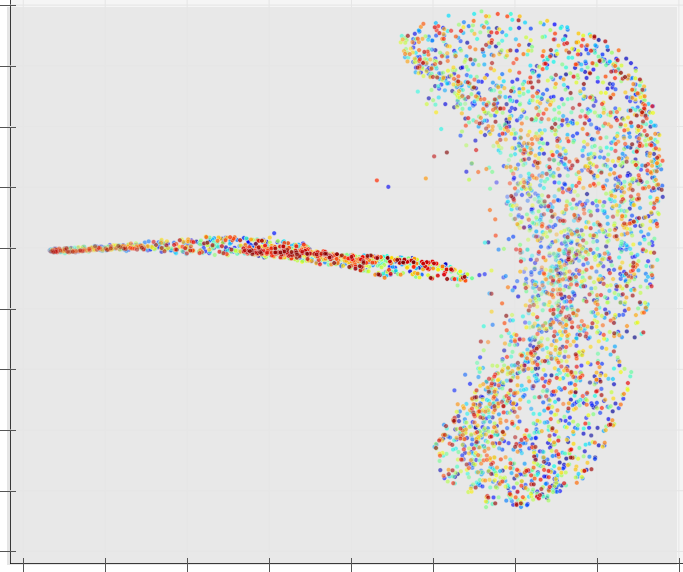

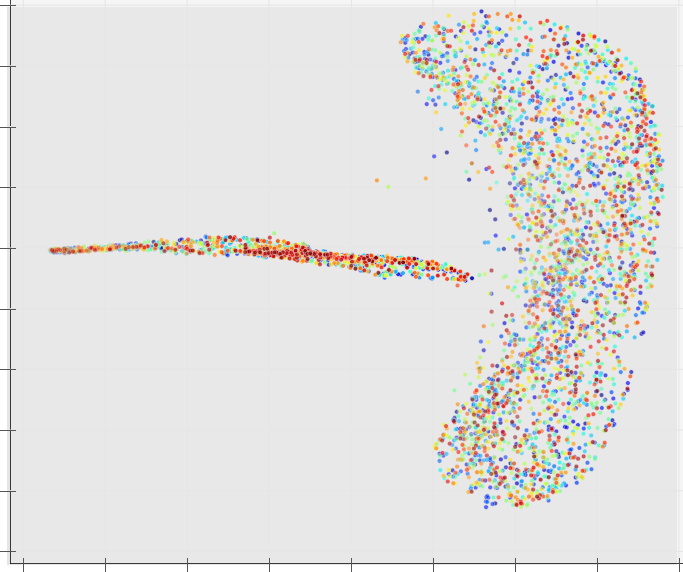

In [149]:
for obs in range(6):
    plot_by_operator(data_dict[1.0],traj1,elev=90,azim=90,dist = 5,operator = traj_expects1.T[obs],filename = "./Figures/FS_absorptive_bistability_QSD_eps1.0_obs"+str(obs)+".pdf")